In [12]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

processor = AutoProcessor.from_pretrained("facebook/nougat-base")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-base")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [14]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    
    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

In [15]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [2]:
import os

root = 'pdf'

# list to store files name
path_list = []
file_list = []
for path, subdirs, files in os.walk(root):
    for name in files:
        file_list.append(os.path.join(path, name))

In [3]:
file_list = [f for f in file_list if ".pdf" in f]
file_list

['pdf/0309/42731/29627355.pdf',
 'pdf/0309/42731/33279945.pdf',
 'pdf/0309/42731/33127438.pdf',
 'pdf/0309/7907/8960488.pdf',
 'pdf/0309/7907/8143100.pdf',
 'pdf/0309/7907/19136433.pdf',
 'pdf/0309/4210/35295623.pdf',
 'pdf/0309/4210/29763019.pdf',
 'pdf/0309/4210/36258995.pdf',
 'pdf/record-141/5119/31092513.pdf',
 'pdf/record-141/5119/29530870.pdf',
 'pdf/record-141/5119/31315808.pdf',
 'pdf/record-141/4280/17699180.pdf',
 'pdf/record-141/4280/31997538.pdf',
 'pdf/record-141/4280/14630731.pdf',
 'pdf/record-141/42731/29627355.pdf',
 'pdf/record-141/42731/33279945.pdf',
 'pdf/record-141/42731/33127438.pdf',
 'pdf/record-37/725/31493201.pdf',
 'pdf/record-37/725/18390527.pdf',
 'pdf/record-37/725/34810164.pdf',
 'pdf/record-37/82021/35029883.pdf',
 'pdf/record-37/82021/36654636.pdf',
 'pdf/record-37/82021/32566366.pdf',
 'pdf/record-37/82021/25419418.pdf',
 'pdf/record-37/E8496/37998311.pdf',
 'pdf/record-37/E8496/29534429.pdf',
 'pdf/record-37/E8496/29117315.pdf',
 'pdf/0005/2809/2563

In [5]:
with open("pdf_list.txt", "w") as f:
    f.write("\n".join(file_list))

In [11]:
len(file_list)

1016

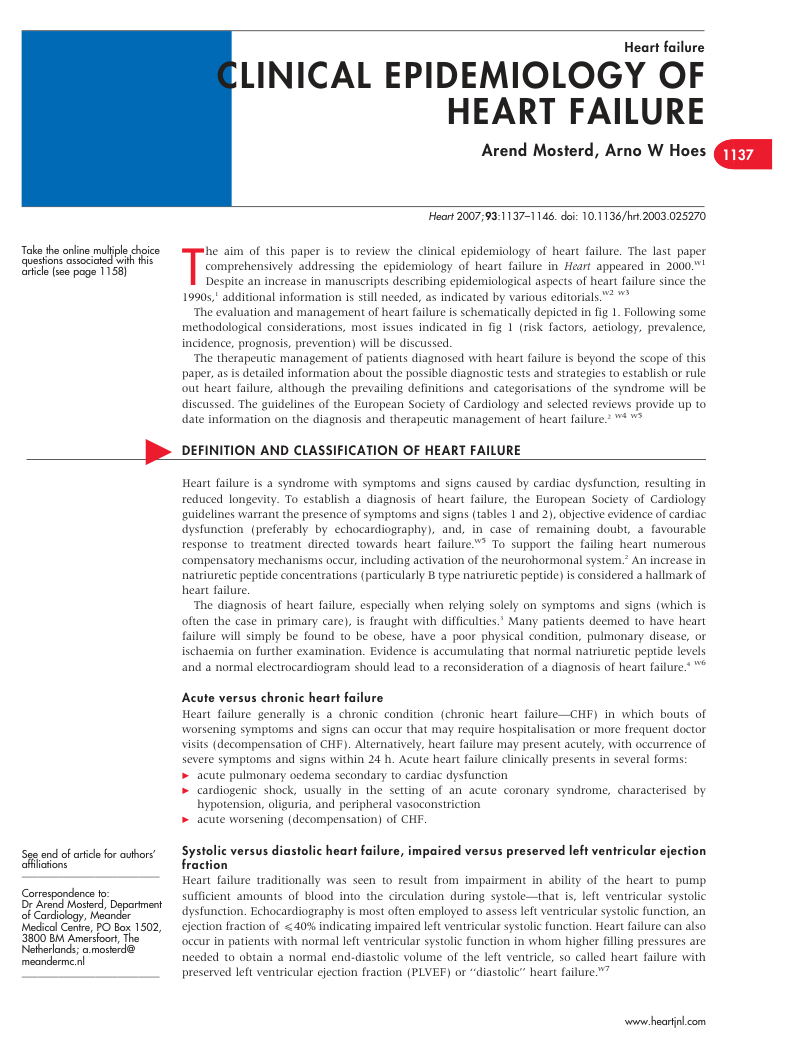

In [16]:
from PIL import Image

filepath = "pdf/0001/4280/17699180.pdf"
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[0])
image

In [17]:
images_list = [Image.open(i) for i in images]

In [18]:
pixel_values = processor(images=images_list, data_format="channels_first", return_tensors="pt").pixel_values

In [19]:
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=3584,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

In [30]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



# Clinical Epidemiology of Heart Failure

Arend Mosterd

Arno W Hoes

# Abstract

The aim of this paper is to review the clinical epidemiology of heart failure. The last paper comprehensively addressing the epidemiology of heart failure in _Heart_ appeared in 2000.w1 Despite an increase in manuscripts describing epidemiological aspects of heart failure since the 1990s,' additional information is still needed, as indicated by various editorials.w2 w3

The evaluation and management of heart failure is schematically depicted in fig 1. Following some methodological considerations, most issues indicated in fig 1 (risk factors, aetiology, prevalence, incidence, prognosis, prevention) will be discussed.

The therapeutic management of patients diagnosed with heart failure is beyond the scope of this paper, as is detailed information about the possible diagnostic tests and strategies to establish or rule out heart failure, although the prevailing definitions and categorisations of the syndrom

In [20]:
outs = processor.batch_decode(outputs[0], skip_special_tokens=True)
len(outs)

10

In [21]:
g = processor.post_process_generation(outs, fix_markdown=False)

In [26]:
for p in g:
    print(p)



# Clinical Epidemiology of Heart Failure

Arend Mosterd

Arno W Hoes

# Abstract

The aim of this paper is to review the clinical epidemiology of heart failure. The last paper comprehensively addressing the epidemiology of heart failure in _Heart_ appeared in 2000.w1 Despite an increase in manuscripts describing epidemiological aspects of heart failure since the 1990s,' additional information is still needed, as indicated by various editorials.w2 w3

The evaluation and management of heart failure is schematically depicted in fig 1. Following some methodological considerations, most issues indicated in fig 1 (risk factors, aetiology, prevalence, incidence, prognosis, prevention) will be discussed.

The therapeutic management of patients diagnosed with heart failure is beyond the scope of this paper, as is detailed information about the possible diagnostic tests and strategies to establish or rule out heart failure, although the prevailing definitions and categorisations of the syndrom